Michael Haugan <br>
MSDS 458 - Spring 2019 <br>
Assignment 3 <br>

# overview

Assignments 1 and 2 concerned neural networks, with a focus on computer vision. This assignment concerns natural language processing. You are asked to create deep neural networks for language processing and to analyze how various factors affect the fitting and ultimate test set performance of these networks.

Network Topologies. Think in terms of exploring alternative network structures/topologies, such as (1) dense versus recurrent neural networks, (2) dense versus one-dimensional convolutional neural networks, and/or (3) recurrent neural networks with and without long short-term memory. Explain your motivation for choosing each topology.

Among the network topologies (structures) you test in this assignment, there should be at least one network with the ability to take the sequence of words into consideration. A useful exercise is to compare processing requirements and predictive accuracy of dense versus recurrent neural networks with long short-term memory.

It is suggested that you work with a text classification problem using the IMDb or Reuters document collections introduced in chapter 3 of Chollet (2018) and demonstrated in the tutorial presented by Paul Huynh (under Modules / Technology Resources). Begin by fitting a fully connected (dense) network, evaluating alternative network structures in terms of their classification performance. Then pursue either a one-dimensional convolutional neural network (CNN) or a recurrent neural network (RNN or LSTM) to classify the same documents. Compare the performance of the word-sequence-enhanced model to the fully-connected model. Sequence models are discussed in chapter 6 of Chollet (2018).

Regarding data sets for natural language processing tasks (in particular, document classification), consider using the Reduced Reuters Corpus.

(Optional) Compare the test set performance and training time for models that begin with one-hot encoding versus models that begin with word embeddings from a public-domain source. Methods for obtaining and working with word embeddings are provided under Modules / Technology Resources.

Hyperparameter Settings. Within each network topology, evaluate alternative settings for hyperparameters. Understand that the tuning of hyperparameter settings may be best accomplished by dividing the available data into training, validation, and test sets.

For each network under study, report on its structure and hyperparameter settings. Report on the time it takes to train each network and the performance of that network in the test set.

Visualizations. Employ visualizations to examine the inner workings of each network under study. Show training and validation set results (loss/cost and performance/accuracy) across epochs.

Management Problem. Suppose you are asked by your current employer to develop a conversational agent or chatbot to assist customer support representatives. What advice would you give management about such development? What kinds of methods and models would be needed?  Would this be a substantial development project? Do you have any ideas about the information infrastructure needed to support conversational agents in a production environment? 

(Optional) Think about the possibilities for a generative language model using these same data. That is, drawing on methods described in chapter 8 of the Chollet (2018, pages 271-279), consider how you might develop a software robot to write movie reviews or news articles. Describe what you would do to build such a model.  If time permits, start with a few words and use a language model to generate subsequent words. Try various degrees of randomness (temperature, as described by Chollet) for the generated text sequences.

# setup

In [210]:
# import packages and set parameters
SET_FIT_INTERCEPT = True
import numpy as np
from scipy.stats import kurtosis
from scipy.stats import skew
import pandas as pd
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.linear_model 
from time import time
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_squared_error, r2_score, make_scorer  
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
import tensorflow as tf
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras import models
from keras import layers
from keras.layers import Dense
from math import sqrt  # for root mean-squared error calculation

#suppress tf.logging
import logging
logging.getLogger('tensorflow').disabled = True

# suppress warning messages
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
import warnings
warnings.filterwarnings('ignore')

# load data

using the imdb dataset which has 50k movie reviews (25k in train set) labeled as positive or negative sentiment. Reviews have been preprocessed, and each review is encoded as a sequence of word indexes (integers). For convenience, words are indexed by overall frequency in the dataset, so that for instance the integer "3" encodes the 3rd most frequent word in the data.

In [275]:
from keras.datasets import imdb
from keras.utils import to_categorical
from keras import preprocessing

max_features = 20000
maxlen = 1000

(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)

print(len(x_train), 'train sequences')
print(len(x_test), 'test sequences')

25000 train sequences
25000 test sequences


In [178]:
# look at first review from training set
print(x_train[0])

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 19193, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 10311, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 12118, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]


In [179]:
# show number of words in first and second reviews
# Note: inputs to NN's need to be the same length so these lengths will all need to be equalized at some point
len(x_train[0]), len(x_train[1])

(218, 189)

In [180]:
# create a function to map integers back to words so we can actually read what a review is saying
word_index = imdb.get_word_index()

# The first indices are reserved
word_index = {k:(v+3) for k,v in word_index.items()} 
word_index["<PAD>"] = 0
word_index["<START>"] = 1
word_index["<UNK>"] = 2  # unknown
word_index["<UNUSED>"] = 3

reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_review(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

In [181]:
# look at first review
decode_review(x_train[0])

"<START> this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert <UNK> is an amazing actor and now the same being director <UNK> father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for retail and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also congratulations to the two little boy's that played the <UNK> of norman and paul they were just brilliant children are often left out of the praising list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be 

# data pre-processing

Because input tensors all need to be the same shape we will use the pad_sequences function to standardize the lengths. 

In [276]:
x_train = preprocessing.sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = preprocessing.sequence.pad_sequences(x_test, maxlen=maxlen)

print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)

x_train shape: (25000, 1000)
x_test shape: (25000, 1000)


In [183]:
# now look at lengths of first and second reviews
len(x_train[0]), len(x_train[1])

(1000, 1000)

In [184]:
# now look at padded second review (notice 0's at the beginning)
print(x_train[1])

[    0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0   

In [277]:
#split train set into a validation set as well. Therefore, test set is never used during training - only train and 
# validation.

# shuffle dataset first
for _ in range(5): 
    indexes = np.random.permutation(len(x_train))

x_train = x_train[indexes]
y_train = y_train[indexes]

x_val = x_train[:10000]
x_train = x_train[10000:]

y_val = y_train[:10000]
y_train = y_train[10000:]

# load plotting helper function

In [186]:
def show_plots(history):
    """ Useful function to view plot of loss values & accuracies across the various epochs """
    loss_vals = history['loss']
    val_loss_vals = history['val_loss']
    epochs = range(1, len(history['acc'])+1)
    
    f, ax = plt.subplots(nrows=1,ncols=2,figsize=(16,4))
    
    # plot losses on ax[0]
    ax[0].plot(epochs, loss_vals, color='navy',marker='o', linestyle=' ', label='Training Loss')
    ax[0].plot(epochs, val_loss_vals, color='firebrick', marker='*', label='Validation Loss')
    ax[0].set_title('Training & Validation Loss')
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Loss')
    ax[0].legend(loc='best')
    ax[0].grid(True)
    
    # plot accuracies
    acc_vals = history['acc']
    val_acc_vals = history['val_acc']

    ax[1].plot(epochs, acc_vals, color='navy', marker='o', ls=' ', label='Training Accuracy')
    ax[1].plot(epochs, val_acc_vals, color='firebrick', marker='*', label='Validation Accuracy')
    ax[1].set_title('Training & Validation Accuracy')
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Accuracy')
    ax[1].legend(loc='best')
    ax[1].grid(True)
    
    plt.show()
    plt.close()
    
    # delete locals from heap before exiting
    del loss_vals, val_loss_vals, epochs, acc_vals, val_acc_vals

# start with simple DNN (fully connected)

In [278]:
def model_build():
    model = models.Sequential()
    model.add(layers.Embedding(max_features, 32, input_length=maxlen))
    model.add(layers.Flatten())
    model.add(layers.Dense(10, activation='relu'))
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [279]:
dnn1 = model_build()

In [280]:
%%time
dnn1_fit = dnn1.fit(x_train, 
         y_train, 
         epochs=10, 
         batch_size=128,
         validation_data=(x_val, y_val),
         verbose=2)

Train on 15000 samples, validate on 10000 samples
Epoch 1/10
 - 5s - loss: 0.6942 - acc: 0.4971 - val_loss: 0.6926 - val_acc: 0.5096
Epoch 2/10
 - 3s - loss: 0.6726 - acc: 0.5551 - val_loss: 0.5267 - val_acc: 0.7618
Epoch 3/10
 - 3s - loss: 0.3640 - acc: 0.8549 - val_loss: 0.2940 - val_acc: 0.8865
Epoch 4/10
 - 3s - loss: 0.1915 - acc: 0.9437 - val_loss: 0.2782 - val_acc: 0.8890
Epoch 5/10
 - 3s - loss: 0.0772 - acc: 0.9800 - val_loss: 0.3221 - val_acc: 0.8827
Epoch 6/10
 - 3s - loss: 0.0323 - acc: 0.9935 - val_loss: 0.3578 - val_acc: 0.8821
Epoch 7/10
 - 3s - loss: 0.0155 - acc: 0.9971 - val_loss: 0.3936 - val_acc: 0.8817
Epoch 8/10
 - 3s - loss: 0.0090 - acc: 0.9983 - val_loss: 0.4322 - val_acc: 0.8812
Epoch 9/10
 - 3s - loss: 0.0059 - acc: 0.9989 - val_loss: 0.4609 - val_acc: 0.8802
Epoch 10/10
 - 3s - loss: 0.0045 - acc: 0.9989 - val_loss: 0.4731 - val_acc: 0.8818
CPU times: user 56.1 s, sys: 19.2 s, total: 1min 15s
Wall time: 35.5 s


In [281]:
test_loss, test_acc = dnn1.evaluate(x_test, y_test)
print('test_acc:', test_acc)

25000/25000 [==============================] - 2s 96us/step
test_acc: 0.87616


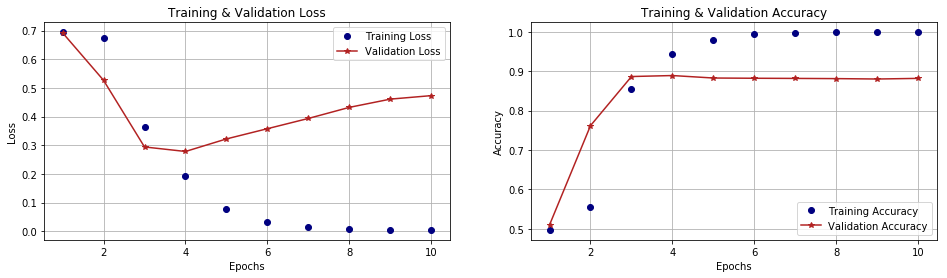

In [282]:
show_plots(dnn1_fit.history)

In [284]:
dnn1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_42 (Embedding)     (None, 1000, 32)          640000    
_________________________________________________________________
flatten_38 (Flatten)         (None, 32000)             0         
_________________________________________________________________
dense_81 (Dense)             (None, 10)                320010    
_________________________________________________________________
dropout_32 (Dropout)         (None, 10)                0         
_________________________________________________________________
dense_82 (Dense)             (None, 1)                 11        
Total params: 960,021
Trainable params: 960,021
Non-trainable params: 0
_________________________________________________________________


We achieve about 87.7% accuracy, which isn't bad for a relatively simple fully connected network. However, overfitting is almost immediately evident. 

# DNN w/ 2 layers

In [192]:
def model_build():
    model = models.Sequential()
    model.add(layers.Embedding(max_features, 32, input_length=maxlen))
    model.add(layers.Flatten())
    model.add(layers.Dense(10, activation='relu'))
    model.add(layers.Dense(20, activation='relu'))
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [193]:
dnn2 = model_build()

In [194]:
%%time
dnn2_fit = dnn2.fit(x_train, 
         y_train, 
         epochs=10, 
         batch_size=128,
         validation_data=(x_val, y_val),
         verbose=2)

Train on 15000 samples, validate on 10000 samples
Epoch 1/10
 - 4s - loss: 0.6934 - acc: 0.4926 - val_loss: 0.6932 - val_acc: 0.4973
Epoch 2/10
 - 3s - loss: 0.6929 - acc: 0.4978 - val_loss: 0.6932 - val_acc: 0.4972
Epoch 3/10
 - 3s - loss: 0.6916 - acc: 0.5045 - val_loss: 0.6926 - val_acc: 0.4998
Epoch 4/10
 - 3s - loss: 0.5066 - acc: 0.7175 - val_loss: 0.3226 - val_acc: 0.8652
Epoch 5/10
 - 3s - loss: 0.1420 - acc: 0.9507 - val_loss: 0.3169 - val_acc: 0.8780
Epoch 6/10
 - 3s - loss: 0.0302 - acc: 0.9936 - val_loss: 0.3862 - val_acc: 0.8722
Epoch 7/10
 - 3s - loss: 0.0090 - acc: 0.9990 - val_loss: 0.4304 - val_acc: 0.8734
Epoch 8/10
 - 3s - loss: 0.0040 - acc: 0.9998 - val_loss: 0.4698 - val_acc: 0.8737
Epoch 9/10
 - 3s - loss: 0.0019 - acc: 0.9999 - val_loss: 0.4963 - val_acc: 0.8741
Epoch 10/10
 - 3s - loss: 0.0013 - acc: 1.0000 - val_loss: 0.5179 - val_acc: 0.8743
CPU times: user 52.9 s, sys: 17.6 s, total: 1min 10s
Wall time: 31.4 s


In [195]:
test_loss, test_acc = dnn2.evaluate(x_test, y_test)
print('test_acc:', test_acc)

25000/25000 [==============================] - 1s 55us/step
test_acc: 0.86584


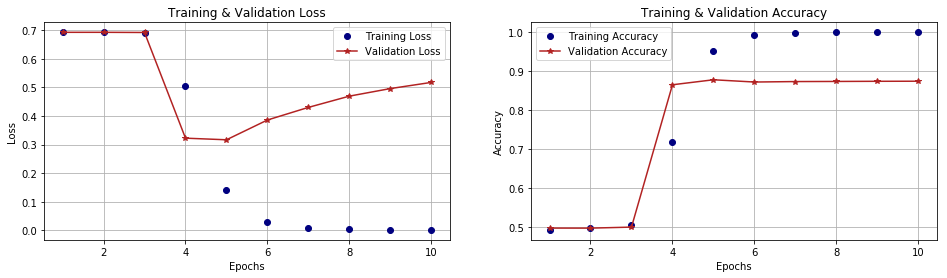

In [196]:
show_plots(dnn2_fit.history)

Accuracy slightly dropped to 86.6% and overfitting is still highly present.

# one-dimension CNN

In [205]:
def model_build():
    model = models.Sequential()
    model.add(layers.Embedding(max_features, 32, input_length=maxlen))
    model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(layers.Flatten())
    model.add(layers.Dense(10, activation='relu'))
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [206]:
cnn1 = model_build()

In [207]:
%%time
cnn1_fit = cnn1.fit(x_train, 
         y_train, 
         epochs=10, 
         batch_size=128,
         validation_data=(x_val, y_val),
         verbose=2)

Train on 15000 samples, validate on 10000 samples
Epoch 1/10
 - 16s - loss: 0.6822 - acc: 0.5296 - val_loss: 0.6053 - val_acc: 0.8035
Epoch 2/10
 - 15s - loss: 0.4922 - acc: 0.8463 - val_loss: 0.4457 - val_acc: 0.8825
Epoch 3/10
 - 16s - loss: 0.3888 - acc: 0.9142 - val_loss: 0.4281 - val_acc: 0.8853
Epoch 4/10
 - 17s - loss: 0.2153 - acc: 0.9339 - val_loss: 0.3254 - val_acc: 0.8858
Epoch 5/10
 - 16s - loss: 0.1216 - acc: 0.9531 - val_loss: 0.3402 - val_acc: 0.8860
Epoch 6/10
 - 15s - loss: 0.0810 - acc: 0.9673 - val_loss: 0.4282 - val_acc: 0.8813
Epoch 7/10
 - 15s - loss: 0.0612 - acc: 0.9719 - val_loss: 0.4631 - val_acc: 0.8826
Epoch 8/10
 - 15s - loss: 0.0482 - acc: 0.9746 - val_loss: 0.5101 - val_acc: 0.8851
Epoch 9/10
 - 15s - loss: 0.0390 - acc: 0.9769 - val_loss: 0.5891 - val_acc: 0.8817
Epoch 10/10
 - 15s - loss: 0.0298 - acc: 0.9781 - val_loss: 0.6936 - val_acc: 0.8808
CPU times: user 4min 52s, sys: 1min 51s, total: 6min 43s
Wall time: 2min 33s


In [208]:
test_loss, test_acc = cnn1.evaluate(x_test, y_test)
print('test_acc:', test_acc)

25000/25000 [==============================] - 8s 337us/step
test_acc: 0.8622


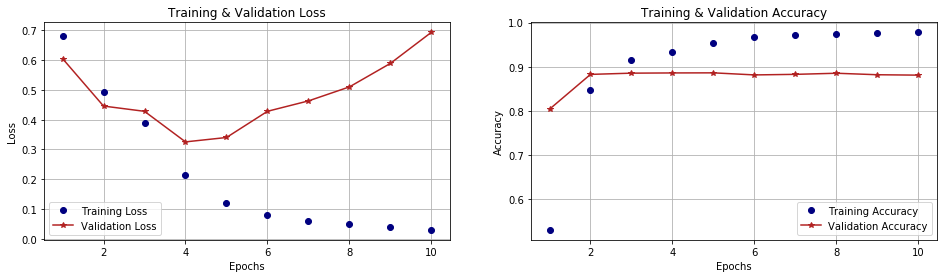

In [209]:
show_plots(cnn1_fit.history)

No improvement in model performance and we still have extremely high overfitting!

# one-dimension CNN w/ 2 layers

In [202]:
def model_build():
    model = models.Sequential()
    model.add(layers.Embedding(max_features, 32, input_length=maxlen))
    model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(layers.Flatten())
    model.add(layers.Dense(10, activation='relu'))
    model.add(layers.Dense(20, activation='relu'))
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [203]:
cnn2 = model_build()

In [204]:
%%time
cnn2_fit = cnn2.fit(x_train, 
         y_train, 
         epochs=10, 
         batch_size=128,
         validation_data=(x_val, y_val),
         verbose=2)

Train on 15000 samples, validate on 10000 samples
Epoch 1/10
 - 16s - loss: 0.6919 - acc: 0.5289 - val_loss: 0.6731 - val_acc: 0.7289
Epoch 2/10
 - 15s - loss: 0.4619 - acc: 0.8184 - val_loss: 0.3268 - val_acc: 0.8648
Epoch 3/10
 - 15s - loss: 0.1959 - acc: 0.9327 - val_loss: 0.2831 - val_acc: 0.8876
Epoch 4/10
 - 15s - loss: 0.1092 - acc: 0.9675 - val_loss: 0.3707 - val_acc: 0.8714
Epoch 5/10
 - 15s - loss: 0.0631 - acc: 0.9851 - val_loss: 0.3724 - val_acc: 0.8884
Epoch 6/10
 - 15s - loss: 0.0427 - acc: 0.9911 - val_loss: 0.4319 - val_acc: 0.8853
Epoch 7/10
 - 15s - loss: 0.0323 - acc: 0.9932 - val_loss: 0.4748 - val_acc: 0.8836
Epoch 8/10
 - 15s - loss: 0.0218 - acc: 0.9963 - val_loss: 0.5370 - val_acc: 0.8807
Epoch 9/10
 - 15s - loss: 0.0173 - acc: 0.9967 - val_loss: 0.5782 - val_acc: 0.8800
Epoch 10/10
 - 15s - loss: 0.0137 - acc: 0.9975 - val_loss: 0.6325 - val_acc: 0.8797
CPU times: user 4min 50s, sys: 1min 48s, total: 6min 38s
Wall time: 2min 29s


In [160]:
test_loss, test_acc = cnn2.evaluate(x_test, y_test)
print('test_acc:', test_acc)

25000/25000 [==============================] - 2s 73us/step
test_acc: 0.85648


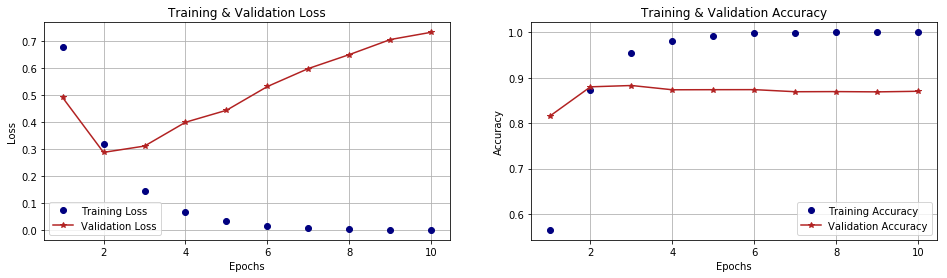

In [161]:
show_plots(cnn2_fit.history)

Again, overfitting is extremely evident and there is no improvement from our DNN performance.

# simple RNN w/o LSTM

In [211]:
def model_build():
    model = models.Sequential()
    model.add(layers.Embedding(max_features, 32, input_length=maxlen))
    model.add(layers.SimpleRNN(32))
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [212]:
rnn1 = model_build()

In [213]:
%%time
rnn1_fit = rnn1.fit(x_train, 
         y_train, 
         epochs=10, 
         batch_size=128,
         validation_data=(x_val, y_val),
         verbose=2)

Train on 15000 samples, validate on 10000 samples
Epoch 1/10
 - 38s - loss: 0.6610 - acc: 0.6031 - val_loss: 0.5749 - val_acc: 0.7358
Epoch 2/10
 - 36s - loss: 0.4380 - acc: 0.8246 - val_loss: 0.3985 - val_acc: 0.8311
Epoch 3/10
 - 35s - loss: 0.2390 - acc: 0.9125 - val_loss: 0.3658 - val_acc: 0.8450
Epoch 4/10
 - 35s - loss: 0.1170 - acc: 0.9641 - val_loss: 0.4306 - val_acc: 0.8198
Epoch 5/10
 - 36s - loss: 0.0604 - acc: 0.9859 - val_loss: 0.4459 - val_acc: 0.8201
Epoch 6/10
 - 36s - loss: 0.0292 - acc: 0.9941 - val_loss: 0.4718 - val_acc: 0.8483
Epoch 7/10
 - 36s - loss: 0.0170 - acc: 0.9975 - val_loss: 0.5130 - val_acc: 0.8434
Epoch 8/10
 - 35s - loss: 0.0150 - acc: 0.9970 - val_loss: 0.5529 - val_acc: 0.8448
Epoch 9/10
 - 38s - loss: 0.0132 - acc: 0.9973 - val_loss: 0.5926 - val_acc: 0.7897
Epoch 10/10
 - 36s - loss: 0.0817 - acc: 0.9709 - val_loss: 0.6114 - val_acc: 0.8381
CPU times: user 13min 33s, sys: 2min 44s, total: 16min 17s
Wall time: 6min 2s


In [214]:
test_loss, test_acc = rnn1.evaluate(x_test, y_test)
print('test_acc:', test_acc)

25000/25000 [==============================] - 48s 2ms/step
test_acc: 0.8292


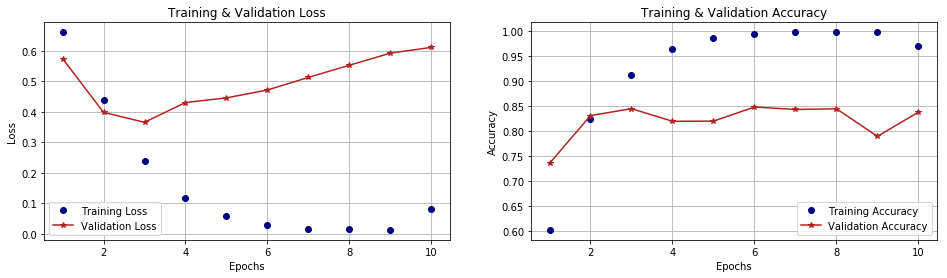

In [215]:
show_plots(rnn1_fit.history)

Accuracy went down and overfitting still highly present

# RNN w/ LSTM

In [216]:
def model_build():
    model = models.Sequential()
    model.add(layers.Embedding(max_features, 32, input_length=maxlen))
    model.add(layers.Dropout(0.2))
    model.add(layers.LSTM(32))
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [217]:
rnn2 = model_build()

In [218]:
%%time
rnn2_fit = rnn2.fit(x_train, 
         y_train, 
         epochs=10, 
         batch_size=128,
         validation_data=(x_val, y_val),
         verbose=2)

Train on 15000 samples, validate on 10000 samples
Epoch 1/10
 - 111s - loss: 0.6380 - acc: 0.6465 - val_loss: 0.4852 - val_acc: 0.7647
Epoch 2/10
 - 106s - loss: 0.3643 - acc: 0.8499 - val_loss: 0.3316 - val_acc: 0.8623
Epoch 3/10
 - 106s - loss: 0.2247 - acc: 0.9188 - val_loss: 0.3446 - val_acc: 0.8501
Epoch 4/10
 - 106s - loss: 0.1455 - acc: 0.9524 - val_loss: 0.3875 - val_acc: 0.8679
Epoch 5/10
 - 107s - loss: 0.0945 - acc: 0.9715 - val_loss: 0.3979 - val_acc: 0.8709
Epoch 6/10
 - 109s - loss: 0.0659 - acc: 0.9823 - val_loss: 0.3991 - val_acc: 0.8652
Epoch 7/10
 - 108s - loss: 0.0484 - acc: 0.9876 - val_loss: 0.4591 - val_acc: 0.8705
Epoch 8/10
 - 106s - loss: 0.0302 - acc: 0.9932 - val_loss: 0.4626 - val_acc: 0.8635
Epoch 9/10
 - 109s - loss: 0.0257 - acc: 0.9937 - val_loss: 0.5062 - val_acc: 0.8546
Epoch 10/10
 - 112s - loss: 0.0824 - acc: 0.9705 - val_loss: 0.7613 - val_acc: 0.8515
CPU times: user 37min 36s, sys: 10min 6s, total: 47min 42s
Wall time: 18min 2s


In [219]:
test_loss, test_acc = rnn2.evaluate(x_test, y_test)
print('test_acc:', test_acc)

25000/25000 [==============================] - 94s 4ms/step
test_acc: 0.83332


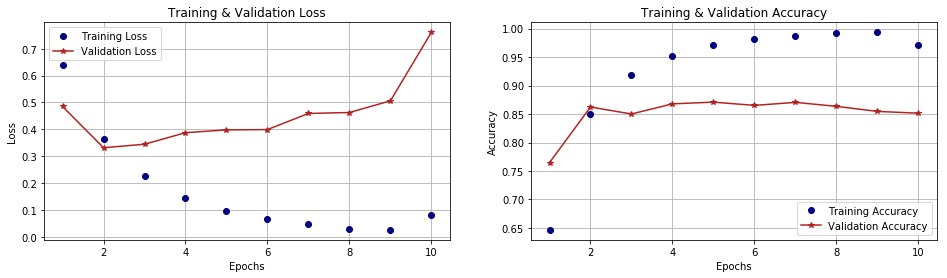

In [220]:
show_plots(rnn2_fit.history)

This approach was the most computationally intensive and returned some of the poorest results in terms of accuracy.

# hyperparameter tune the first DNN (1 layer)

In [231]:
def model_build():
    model = models.Sequential()
    model.add(layers.Embedding(max_features, 32, input_length=maxlen))
    model.add(layers.Flatten())
    model.add(layers.Dense(32, activation='relu'))
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [232]:
dnn3 = model_build()

In [233]:
%%time
dnn3_fit = dnn3.fit(x_train, 
         y_train, 
         epochs=10, 
         batch_size=128,
         validation_data=(x_val, y_val),
         verbose=2)

Train on 15000 samples, validate on 10000 samples
Epoch 1/10
 - 6s - loss: 0.6177 - acc: 0.6539 - val_loss: 0.3968 - val_acc: 0.8510
Epoch 2/10
 - 4s - loss: 0.2726 - acc: 0.8959 - val_loss: 0.2750 - val_acc: 0.8879
Epoch 3/10
 - 4s - loss: 0.1107 - acc: 0.9663 - val_loss: 0.2871 - val_acc: 0.8899
Epoch 4/10
 - 5s - loss: 0.0407 - acc: 0.9921 - val_loss: 0.3215 - val_acc: 0.8856
Epoch 5/10
 - 4s - loss: 0.0154 - acc: 0.9984 - val_loss: 0.3555 - val_acc: 0.8861
Epoch 6/10
 - 4s - loss: 0.0060 - acc: 0.9997 - val_loss: 0.3881 - val_acc: 0.8849
Epoch 7/10
 - 4s - loss: 0.0036 - acc: 1.0000 - val_loss: 0.4142 - val_acc: 0.8860
Epoch 8/10
 - 4s - loss: 0.0021 - acc: 1.0000 - val_loss: 0.4404 - val_acc: 0.8862
Epoch 9/10
 - 4s - loss: 0.0016 - acc: 1.0000 - val_loss: 0.4639 - val_acc: 0.8860
Epoch 10/10
 - 4s - loss: 0.0012 - acc: 0.9999 - val_loss: 0.4835 - val_acc: 0.8855
CPU times: user 1min 24s, sys: 23.5 s, total: 1min 48s
Wall time: 46.9 s


In [234]:
test_loss, test_acc = dnn3.evaluate(x_test, y_test)
print('test_acc:', test_acc)

25000/25000 [==============================] - 3s 118us/step
test_acc: 0.8766


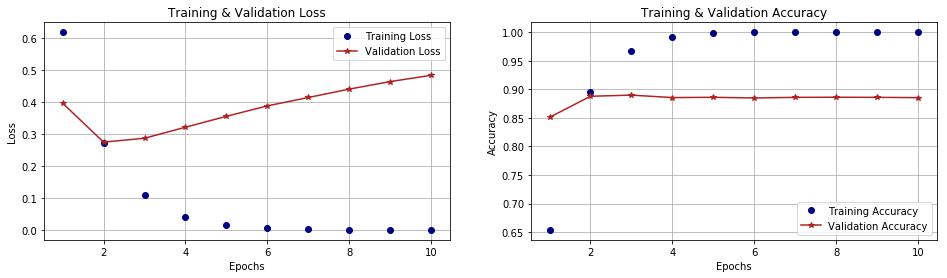

In [235]:
show_plots(dnn3_fit.history)

In [246]:
# add regularization
from keras import regularizers

def model_build():
    model = models.Sequential()
    model.add(layers.Embedding(max_features, 32, input_length=maxlen))
    model.add(layers.Flatten())
    model.add(layers.Dense(32, kernel_regularizer=regularizers.l2(0.001), activation='relu'))
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [247]:
dnn4 = model_build()

In [248]:
%%time
dnn4_fit = dnn4.fit(x_train, 
         y_train, 
         epochs=10, 
         batch_size=128,
         validation_data=(x_val, y_val),
         verbose=2)

Train on 15000 samples, validate on 10000 samples
Epoch 1/10
 - 7s - loss: 0.7232 - acc: 0.4995 - val_loss: 0.7031 - val_acc: 0.4989
Epoch 2/10
 - 5s - loss: 0.6944 - acc: 0.5386 - val_loss: 0.5581 - val_acc: 0.8003
Epoch 3/10
 - 5s - loss: 0.3792 - acc: 0.8735 - val_loss: 0.3489 - val_acc: 0.8855
Epoch 4/10
 - 5s - loss: 0.1886 - acc: 0.9637 - val_loss: 0.3367 - val_acc: 0.8874
Epoch 5/10
 - 5s - loss: 0.1162 - acc: 0.9896 - val_loss: 0.3321 - val_acc: 0.8863
Epoch 6/10
 - 5s - loss: 0.0838 - acc: 0.9973 - val_loss: 0.3265 - val_acc: 0.8890
Epoch 7/10
 - 5s - loss: 0.0653 - acc: 0.9991 - val_loss: 0.3431 - val_acc: 0.8826
Epoch 8/10
 - 5s - loss: 0.0540 - acc: 0.9995 - val_loss: 0.3269 - val_acc: 0.8854
Epoch 9/10
 - 5s - loss: 0.0462 - acc: 0.9996 - val_loss: 0.3242 - val_acc: 0.8866
Epoch 10/10
 - 6s - loss: 0.0404 - acc: 0.9999 - val_loss: 0.3269 - val_acc: 0.8837
CPU times: user 1min 31s, sys: 27.8 s, total: 1min 59s
Wall time: 52.4 s


In [249]:
test_loss, test_acc = dnn4.evaluate(x_test, y_test)
print('test_acc:', test_acc)

25000/25000 [==============================] - 4s 155us/step
test_acc: 0.87436


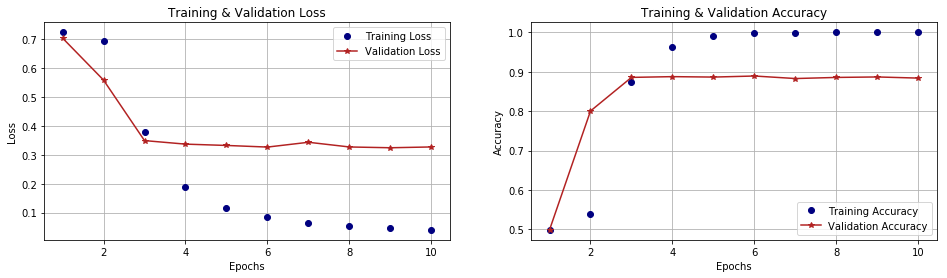

In [250]:
show_plots(dnn4_fit.history)

Higher dropout levels and regularization thresholds could be used to further reduce overfitting.